In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression
import numpy as np

/Users/yingrongmao/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
with open("diversity_time_to_drop.json","r") as f:
    data = json.load(f)

In [3]:
df = pd.DataFrame(data).T
df.head()

,diversity,time_to_drop
cluster_4,0.692681,3.0
cluster_5,0.827765,1.0
cluster_9,0.736523,1.0
cluster_20,0.740763,4.0
cluster_21,0.765880,1.0


In [4]:
with open("meme_table.csv","r") as f:
    meme_table = pd.read_csv(f)

In [5]:
meme_table.head()

,meme_id,cluster,created_utc,title,selftext,author,num_comments,score,extracted_text,comments_text,created_date
0,cawlo8,cluster_4,1.562651e+09,"I have an MIDI keyboard, just no plug for it ):",NaN,YTMusicXD,0,3,When you want to easily make midi; limited pow...,NaN,2019-07-09
1,d72m1n,cluster_4,1.569021e+09,R.I.P,NaN,masnargom,0,95,When Imina room full of antivax children and f...,NaN,2019-09-20
2,bo6k2s,cluster_4,1.557769e+09,It's like a life hack,NaN,emanuelegay,2,4,Connect one Power Bank to another one Unlimite...,This is just plug in a power strip to itself\n...,2019-05-13
3,cr40bc,cluster_4,1.565948e+09,I Finally Have Unlimited Power,NaN,Zaxoosh,0,64,When you finally get enough karma to post on r...,NaN,2019-08-16
4,apoel0,cluster_4,1.549939e+09,Crrevt,NaN,memeboiiii7059,0,7,whwn yoy make a meme wirh one hand Unlimited p...,NaN,2019-02-12


In [6]:
# Ensure created_date is in datetime format
meme_table['created_date'] = pd.to_datetime(meme_table['created_date'])

# Extract year-month
meme_table['year_month'] = meme_table['created_date'].dt.to_period('M')

# Calculate cluster frequency per month
cluster_monthly_freq = meme_table.groupby(['year_month', 'cluster']).size().reset_index(name='frequency')

# Find the maximum frequency for each cluster
max_freq_per_cluster = cluster_monthly_freq.groupby('cluster')['frequency'].max().reset_index()

# Display results
print("Cluster Frequency Per Month:")
print(cluster_monthly_freq)

print("\nMaximum Frequency Per Cluster:")
print(max_freq_per_cluster)

Cluster Frequency Per Month:
      year_month       cluster  frequency
0        2011-09   Acluster_74          1
1        2011-09   cluster_807          1
2        2011-10   Acluster_74          1
3        2011-10  cluster_1800          1
4        2011-10   cluster_693          1
...          ...           ...        ...
17321    2023-12  cluster_8435          1
17322    2023-12  cluster_8589          1
17323    2023-12  cluster_8705          1
17324    2023-12   cluster_882          1
17325    2023-12   cluster_909          2

[17326 rows x 3 columns]

Maximum Frequency Per Cluster:
           cluster  frequency
0       Acluster_0         17
1     Acluster_121         15
2     Acluster_122         23
3     Acluster_134         64
4    Acluster_1353         34
..             ...        ...
455    cluster_967         26
456     cluster_97         22
457    cluster_984         32
458   cluster_9918         27
459    cluster_997         18

[460 rows x 2 columns]


In [7]:
# Filter max_freq_per_cluster to include only clusters that are in the index of new_df
cluster_300 = max_freq_per_cluster[max_freq_per_cluster["cluster"].isin(new_df.index)]
print(cluster_300)

NameError: name 'new_df' is not defined

In [8]:
# Set the 'cluster' column as the index for joining
max_freq_per_cluster.set_index('cluster', inplace=True)

In [10]:
# Combine with new_df using the index
df = df.join(max_freq_per_cluster, how='left')

df.head()

,diversity,time_to_drop,frequency
cluster_4,0.692681,3.0,10
cluster_5,0.827765,1.0,119
cluster_9,0.736523,1.0,13
cluster_20,0.740763,4.0,20
cluster_21,0.765880,1.0,20


In [11]:
for i in meme_table["cluster"].unique():
    length = len(meme_table[meme_table["cluster"]==i])
    df.loc[i,"meme_count"] = length

In [12]:
df.head()

,diversity,time_to_drop,frequency,meme_count
cluster_4,0.692681,3.0,10,103.0
cluster_5,0.827765,1.0,119,933.0
cluster_9,0.736523,1.0,13,132.0
cluster_20,0.740763,4.0,20,252.0
cluster_21,0.765880,1.0,20,251.0


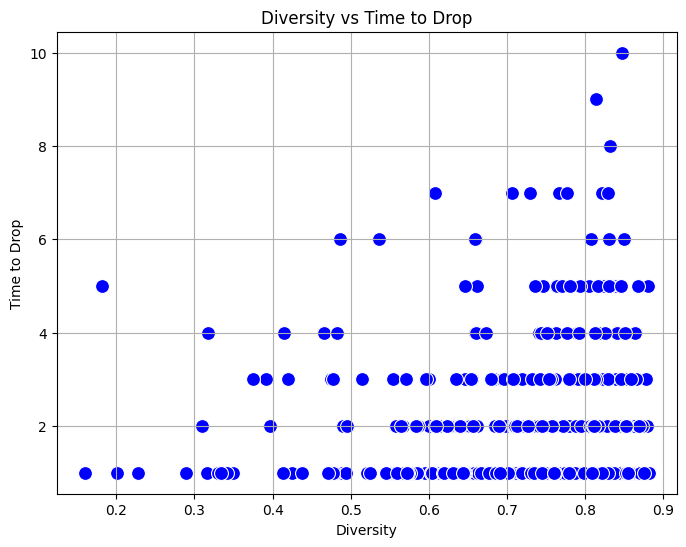

In [13]:
# Scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="diversity", y="time_to_drop", s=100, color="blue")
plt.title("Diversity vs Time to Drop")
plt.xlabel("Diversity")
plt.ylabel("Time to Drop")
plt.grid(True)
plt.show()

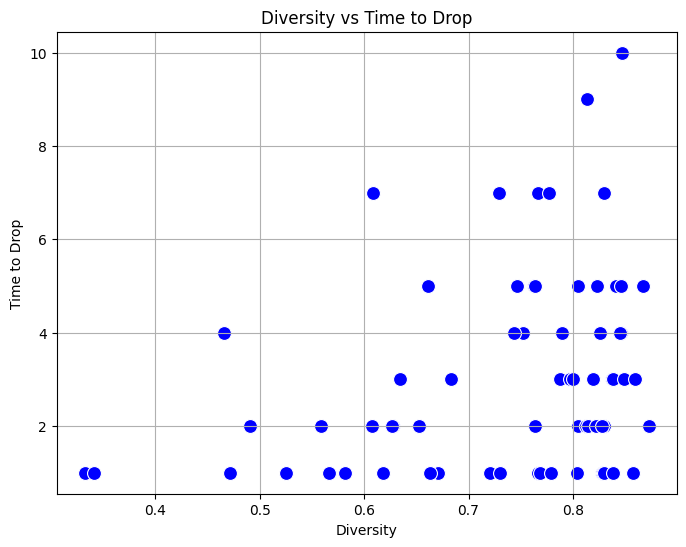

In [14]:
# Scatter plot
new_df = df[df["meme_count"]>300]
plt.figure(figsize=(8, 6))
sns.scatterplot(data=new_df, x="diversity", y="time_to_drop", s=100, color="blue")
plt.title("Diversity vs Time to Drop")
plt.xlabel("Diversity")
plt.ylabel("Time to Drop")
plt.grid(True)
plt.show()

In [15]:
df["time_to_drop"].value_counts()

time_to_drop
1.0     217
2.0     124
3.0      53
4.0      25
5.0      23
7.0       7
6.0       7
10.0      1
9.0       1
8.0       1
inf       1
Name: count, dtype: int64

In [16]:
df = df[df["time_to_drop"] != np.inf]

In [17]:
# Correlation analysis
pearson_corr, pearson_pval = pearsonr(new_df["diversity"], new_df["meme_count"])
spearman_corr, spearman_pval = spearmanr(new_df["diversity"], new_df["meme_count"])
print(f"Pearson correlation: {pearson_corr:.3f}, p-value: {pearson_pval:.3f}")
print(f"Spearman correlation: {spearman_corr:.3f}, p-value: {spearman_pval:.3f}")

Pearson correlation: 0.142, p-value: 0.253
Spearman correlation: 0.074, p-value: 0.552


Regression Coefficient (Slope): 0.998
Regression Intercept: 1.362


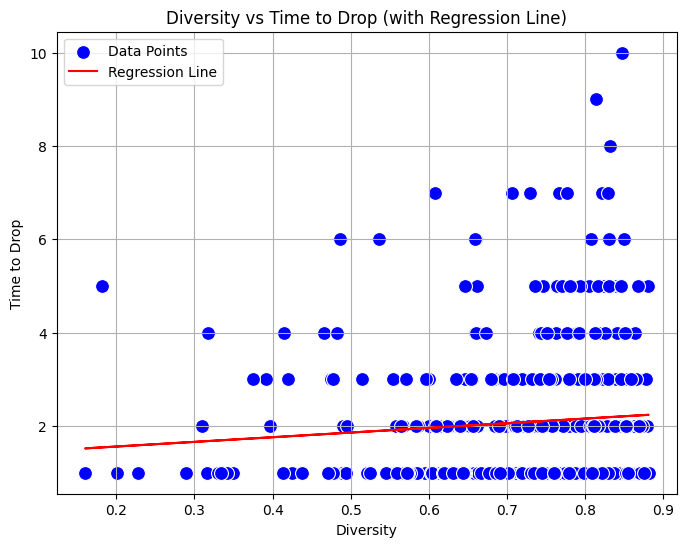

In [18]:
# Regression analysis
X = df["diversity"].values.reshape(-1, 1)  # Predictor
y = df["time_to_drop"].values  # Response

reg = LinearRegression()
reg.fit(X, y)

# Regression results
print(f"Regression Coefficient (Slope): {reg.coef_[0]:.3f}")
print(f"Regression Intercept: {reg.intercept_:.3f}")

# Plot regression line
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="diversity", y="time_to_drop", s=100, color="blue", label="Data Points")
plt.plot(df["diversity"], reg.predict(X), color="red", label="Regression Line")
plt.title("Diversity vs Time to Drop (with Regression Line)")
plt.xlabel("Diversity")
plt.ylabel("Time to Drop")
plt.legend()
plt.grid(True)
plt.show()

Pearson correlation: 0.283, p-value: 0.020
Spearman correlation: 0.268, p-value: 0.028
Regression Coefficient (Slope): 4.764
Regression Intercept: -0.445


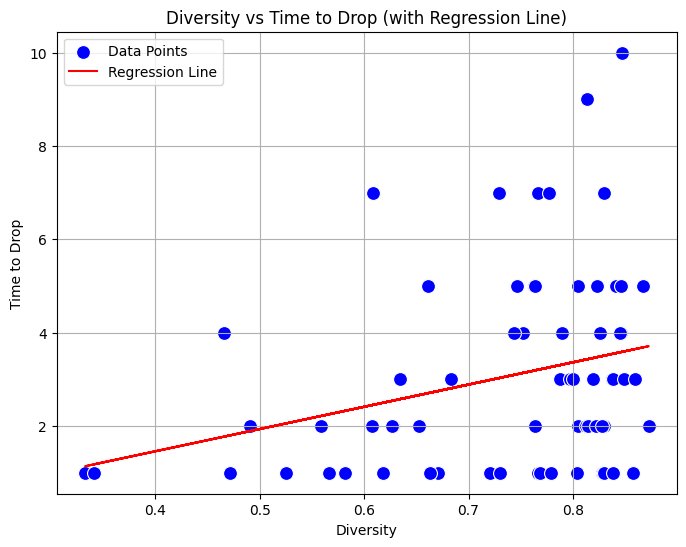

In [19]:
new_df = df[df["meme_count"]>300]

# Correlation analysis
pearson_corr, pearson_pval = pearsonr(new_df["diversity"], new_df["time_to_drop"])
spearman_corr, spearman_pval = spearmanr(new_df["diversity"], new_df["time_to_drop"])
print(f"Pearson correlation: {pearson_corr:.3f}, p-value: {pearson_pval:.3f}")
print(f"Spearman correlation: {spearman_corr:.3f}, p-value: {spearman_pval:.3f}")

# Regression analysis
X = new_df["diversity"].values.reshape(-1, 1)  # Predictor
y = new_df["time_to_drop"].values  # Response

reg = LinearRegression()
reg.fit(X, y)

# Regression results
print(f"Regression Coefficient (Slope): {reg.coef_[0]:.3f}")
print(f"Regression Intercept: {reg.intercept_:.3f}")

# Plot regression line
plt.figure(figsize=(8, 6))
sns.scatterplot(data=new_df, x="diversity", y="time_to_drop", s=100, color="blue", label="Data Points")
plt.plot(new_df["diversity"], reg.predict(X), color="red", label="Regression Line")
plt.title("Diversity vs Time to Drop (with Regression Line)")
plt.xlabel("Diversity")
plt.ylabel("Time to Drop")
plt.legend()
plt.grid(True)
plt.show()

In [20]:
import statsmodels.api as sm
# Define dependent and independent variables
new_df = df[df["meme_count"]>300]

X = new_df[["diversity", "meme_count"]]  # Independent variables
y = new_df["time_to_drop"]               # Dependent variable

# Add a constant for the intercept
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           time_to_drop   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     13.89
Date:                Thu, 12 Dec 2024   Prob (F-statistic):           9.74e-06
Time:                        01:25:31   Log-Likelihood:                -133.40
No. Observations:                  67   AIC:                             272.8
Df Residuals:                      64   BIC:                             279.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3864      1.329     -1.043      0.3

In [21]:
import statsmodels.api as sm
# Define dependent and independent variables
new_df = df[df["meme_count"]>300]

X = new_df[["diversity"]]  # Independent variables
y = new_df["time_to_drop"]               # Dependent variable

# Add a constant for the intercept
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           time_to_drop   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     5.646
Date:                Thu, 12 Dec 2024   Prob (F-statistic):             0.0204
Time:                        01:25:35   Log-Likelihood:                -142.69
No. Observations:                  67   AIC:                             289.4
Df Residuals:                      65   BIC:                             293.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4453      1.497     -0.298      0.7

In [50]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

      feature        VIF
0       const  36.010778
1   diversity   1.020458
2  meme_count   1.020458


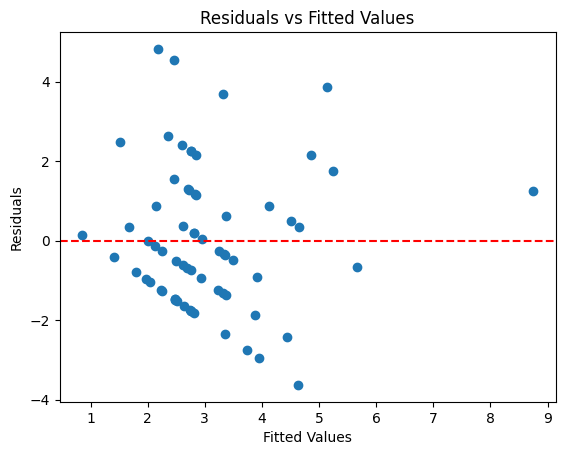

In [51]:
import matplotlib.pyplot as plt
plt.scatter(model.fittedvalues, model.resid)
plt.axhline(y=0, color="red", linestyle="--")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.show()

In [52]:
model_robust = sm.RLM(y, X).fit()
print(model_robust.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:           time_to_drop   No. Observations:                   67
Model:                            RLM   Df Residuals:                       64
Method:                          IRLS   Df Model:                            2
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 01 Dec 2024                                         
Time:                        19:53:28                                         
No. Iterations:                    11                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.7284      1.315     -1.315      0.1